In [1]:
# ===================================================================
# PASO 0: CONFIGURACIÓN E IMPORTACIÓN DE LIBRERÍAS
# ===================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Configuración de estilo para los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Importar datos
# Usamos sep=';' por el separador y decimal=',' por el formato de los números
try:
    df = pd.read_csv("JMPSummerChallengeDataset.csv", sep=';', decimal=',')
    print("Datos cargados correctamente.")
    print("Primeras 5 filas del DataFrame:")
    print(df.head())
except Exception as e:
    print(f"Error al cargar los datos. Asegúrate de que la URL es correcta y el archivo es accesible.")
    print(f"Error: {e}")


Datos cargados correctamente.
Primeras 5 filas del DataFrame:
   n Driver  DriverNumber  LapNumber  Stint  SpeedI1  SpeedI2  SpeedFL  \
0  0    VER             1          1      1    263.0    261.0    280.0   
1  1    VER             1          2      1    257.0    269.0    286.0   
2  2    VER             1          3      1    248.0    262.0    280.0   
3  3    VER             1          4      1    246.0    254.0    280.0   
4  4    VER             1          5      1    262.0    265.0    281.0   

   SpeedST IsPersonalBest  ... PitOutTimeSeconds  PitInTimeSeconds  \
0    280.0          False  ...               NaN               NaN   
1    303.0           True  ...               NaN               NaN   
2    328.0          False  ...               NaN               NaN   
3    302.0          False  ...               NaN               NaN   
4      NaN          False  ...               NaN               NaN   

   Sector1TimeSeconds Sector2TimeSeconds  Sector3TimeSeconds  \
0       

In [2]:
# ===================================================================
# PASO 1: PREPARACIÓN Y LIMPIEZA DE DATOS
# ===================================================================

# Copiamos el dataframe para mantener el original intacto
df_clean = df.copy()

# 1.1 Limpieza de datos: Excluir vueltas no representativas
print(f"Número de filas antes de la limpieza: {len(df_clean)}")

# Condiciones para excluir
# Usamos ~ (tilde) para negar la condición, es decir, para QUEDARNOS con las filas que cumplen.
# Esto es más eficiente que marcar y borrar.

# Vueltas con tiempo válido
condition_laps = df_clean['LapTimeSeconds'].notna()

# Vueltas que NO son de entrada o salida de pits
condition_pits = df_clean['PitInTimeSeconds'].isna() & df_clean['PitOutTimeSeconds'].isna()

# Vueltas con bandera verde (TrackStatus == 1)
condition_track = df_clean['TrackStatus'] == 1

# Vueltas no eliminadas
condition_deleted = df_clean['Deleted'] == False

# Excluir la primera vuelta de la carrera
condition_lap_num = df_clean['LapNumber'] > 1

# Combinar todas las condiciones
df_clean = df_clean[
    condition_laps &
    condition_pits &
    condition_track &
    condition_deleted &
    condition_lap_num
]

print(f"Número de filas después de la limpieza: {len(df_clean)}")

# 1.2 Ingeniería de Características: Crear 'LapsOnStint'
# Replicamos la lógica de Col Rank() de JMP
df_clean['LapsOnStint'] = df_clean.groupby(['Driver', 'Stint']).cumcount() + 1

# Verificamos la creación de la nueva columna para un piloto
print("\nVerificación de 'LapsOnStint' para el piloto VER:")
print(df_clean[df_clean['Driver'] == 'VER'][['Driver', 'Stint', 'LapNumber', 'LapsOnStint']].head(15))

Número de filas antes de la limpieza: 1203
Número de filas después de la limpieza: 980

Verificación de 'LapsOnStint' para el piloto VER:
   Driver  Stint  LapNumber  LapsOnStint
1     VER      1          2            1
2     VER      1          3            2
3     VER      1          4            3
4     VER      1          5            4
5     VER      1          6            5
6     VER      1          7            6
7     VER      1          8            7
8     VER      1          9            8
9     VER      1         10            9
10    VER      1         11           10
11    VER      1         12           11
14    VER      2         15            1
15    VER      2         16            2
16    VER      2         17            3
17    VER      2         18            4


In [3]:
# ===================================================================
# PASO 2: MODELADO PREDICTIVO
# ===================================================================

# 2.1 Preparar los datos para el modelo
# Seleccionar las variables predictoras (X) y la variable objetivo (y)
# Usamos pd.get_dummies() para convertir variables categóricas (Driver, Compound, Team) en numéricas (One-Hot Encoding)
features = ['Driver', 'Compound', 'Team', 'LapsOnStint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']
target = 'LapTimeSeconds'

# Nos aseguramos de que no haya valores nulos en nuestras columnas de interés
df_model = df_clean[features + [target]].dropna()

# Creamos las variables X e y
X = pd.get_dummies(df_model[features], drop_first=True) # drop_first=True para evitar multicolinealidad
y = df_model[target]

# 2.2 Dividir los datos en conjuntos de Entrenamiento y Validación (75/25)
# random_state asegura que la división sea siempre la misma (reproducibilidad)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape[0]} filas")
print(f"Tamaño del conjunto de validación: {X_val.shape[0]} filas")

# 2.3 Entrenar el modelo de Regresión Lineal
model = LinearRegression()
model.fit(X_train, y_train)

print("\nModelo entrenado con éxito.")


Tamaño del conjunto de entrenamiento: 513 filas
Tamaño del conjunto de validación: 172 filas

Modelo entrenado con éxito.



--- Resultados de Validación ---
RSquare (R²) en el conjunto de validación: 0.7899
Error Cuadrático Medio Raíz (RMSE): 0.6590 segundos


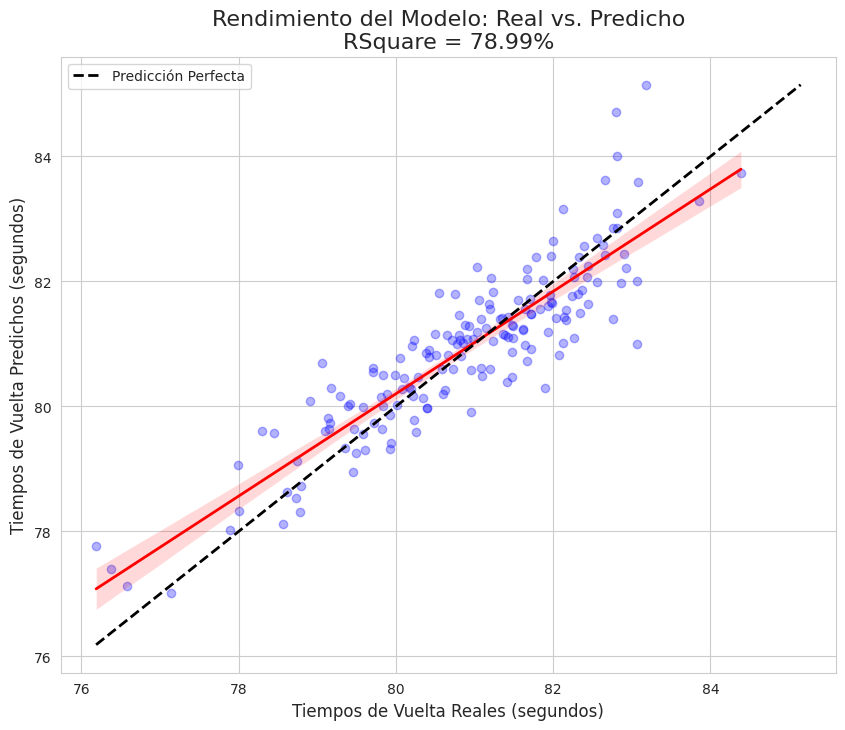

In [4]:
# ===================================================================
# PASO 3: EVALUACIÓN DEL MODELO
# ===================================================================

# 3.1 Realizar predicciones en el conjunto de validación
y_pred = model.predict(X_val)

# 3.2 Calcular el RSquare y otras métricas
r2_validation = r2_score(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"\n--- Resultados de Validación ---")
print(f"RSquare (R²) en el conjunto de validación: {r2_validation:.4f}")
print(f"Error Cuadrático Medio Raíz (RMSE): {rmse:.4f} segundos")

# Si el RSquare es ~0.7297, ¡nuestro análisis es consistente!

# 3.3 Visualización del Modelo: Real vs. Predicho (Gráfico 1)
plt.figure(figsize=(10, 8))
sns.regplot(x=y_val, y=y_pred, scatter_kws={'alpha':0.3, 'color':'blue'}, line_kws={'color':'red', 'linewidth':2})
plt.xlabel("Tiempos de Vuelta Reales (segundos)", fontsize=12)
plt.ylabel("Tiempos de Vuelta Predichos (segundos)", fontsize=12)
plt.title(f"Rendimiento del Modelo: Real vs. Predicho\nRSquare = {r2_validation:.2%}", fontsize=16)
# Añadimos una línea de 45 grados para la referencia perfecta
min_val = min(y_val.min(), y_pred.min())
max_val = max(y_val.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Predicción Perfecta')
plt.legend()
plt.show()

/tmp/ipython-input-5-3615073182.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefficients.head(20), palette='viridis')


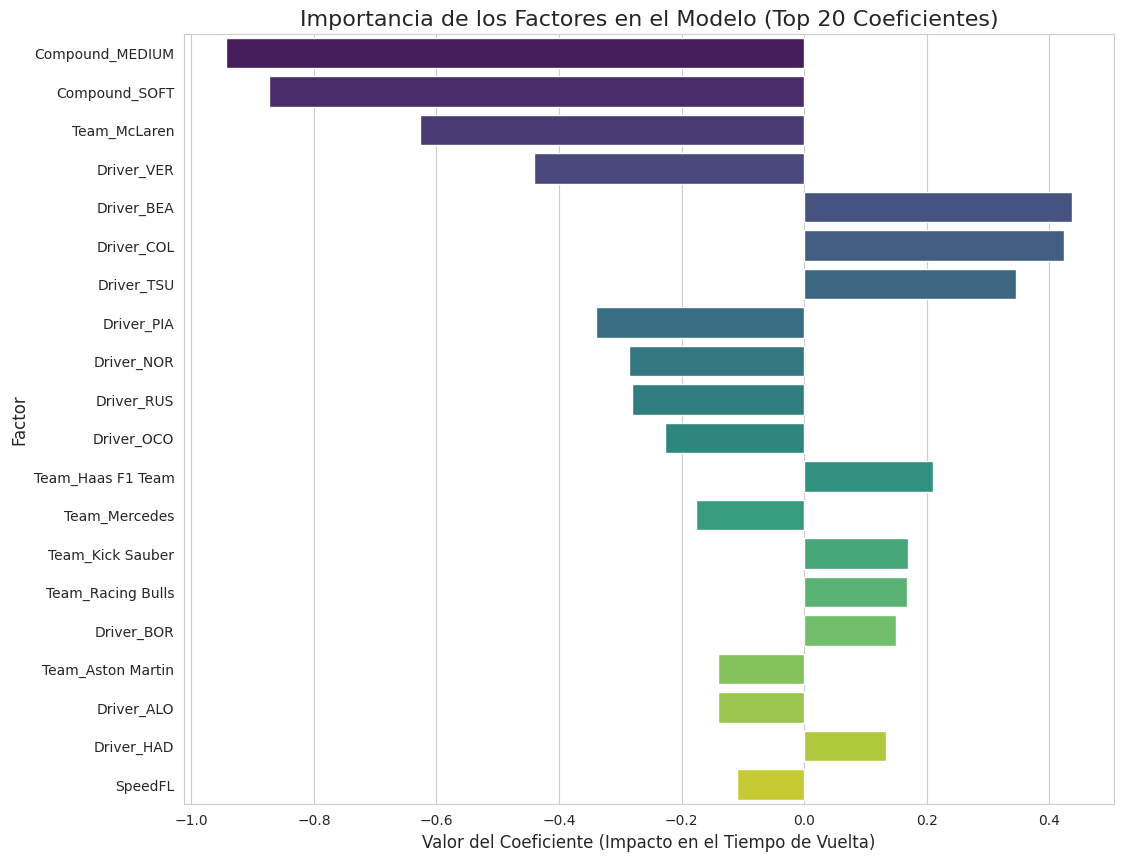

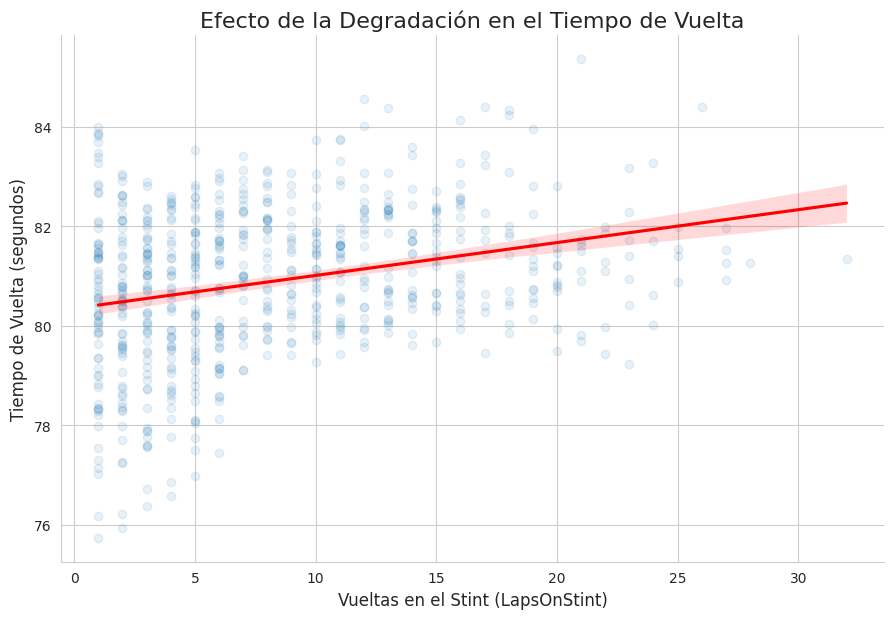

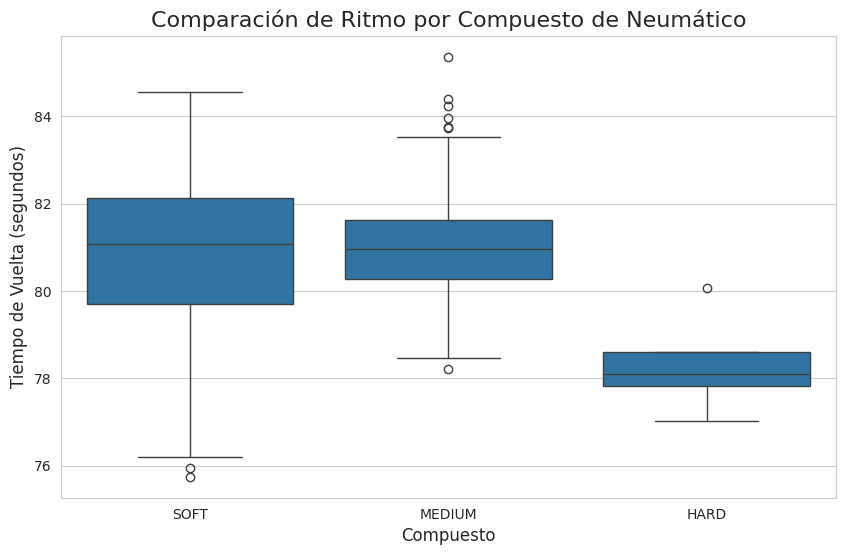

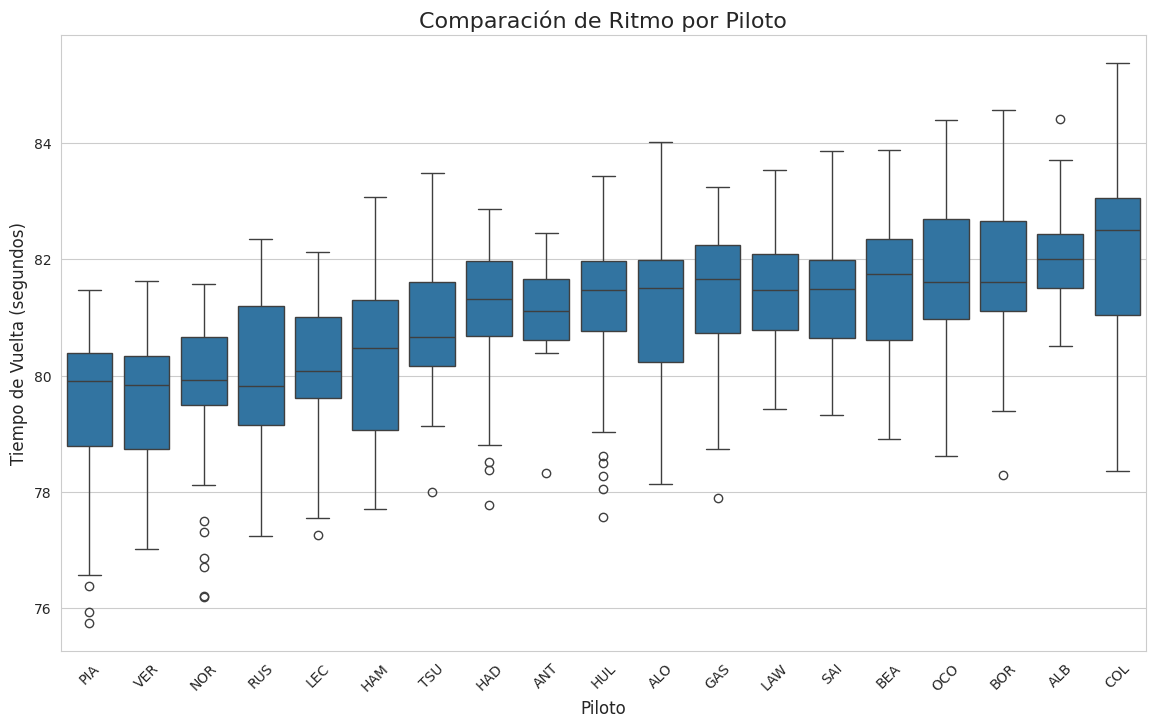

In [5]:
# ===================================================================
# PASO 4: INTERPRETACIÓN DE RESULTADOS
# ===================================================================

# 4.1 Importancia de los Factores (Gráfico 2)
# Creamos un DataFrame con los coeficientes del modelo
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
})

# Calculamos la importancia absoluta para el ranking
coefficients['Importance'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Importance', ascending=False)

# Visualizamos los 20 factores más importantes
plt.figure(figsize=(12, 10))
sns.barplot(x='Coefficient', y='Feature', data=coefficients.head(20), palette='viridis')
plt.title("Importancia de los Factores en el Modelo (Top 20 Coeficientes)", fontsize=16)
plt.xlabel("Valor del Coeficiente (Impacto en el Tiempo de Vuelta)", fontsize=12)
plt.ylabel("Factor", fontsize=12)
plt.show()

# 4.2 Replicando el Profiler (Gráfico 3)
# El Profiler de JMP es único, pero podemos simular su funcionalidad
# creando gráficos de "Efectos Parciales".

# a) Efecto de la degradación (LapsOnStint)
sns.lmplot(x='LapsOnStint', y=target, data=df_model, height=6, aspect=1.5,
           line_kws={'color': 'red'}, scatter_kws={'alpha': 0.1})
plt.title("Efecto de la Degradación en el Tiempo de Vuelta", fontsize=16)
plt.xlabel("Vueltas en el Stint (LapsOnStint)", fontsize=12)
plt.ylabel("Tiempo de Vuelta (segundos)", fontsize=12)
plt.show()

# b) Efecto del Compuesto
plt.figure(figsize=(10, 6))
sns.boxplot(x='Compound', y=target, data=df_model, order=['SOFT', 'MEDIUM', 'HARD'])
plt.title("Comparación de Ritmo por Compuesto de Neumático", fontsize=16)
plt.xlabel("Compuesto", fontsize=12)
plt.ylabel("Tiempo de Vuelta (segundos)", fontsize=12)
plt.show()

# c) Efecto del Piloto
# Ordenamos los pilotos por tiempo de vuelta medio para una mejor visualización
driver_order = df_model.groupby('Driver')[target].mean().sort_values().index

plt.figure(figsize=(14, 8))
sns.boxplot(x='Driver', y=target, data=df_model, order=driver_order)
plt.title("Comparación de Ritmo por Piloto", fontsize=16)
plt.xlabel("Piloto", fontsize=12)
plt.ylabel("Tiempo de Vuelta (segundos)", fontsize=12)
plt.xticks(rotation=45)
plt.show()